In [1]:
%matplotlib inline

In [2]:
%run exoplanet/notebook_setup.py

theano version: 1.0.4
pymc3 version: 3.7
exoplanet version: 0.3.3
scipy version: 1.5.2


In [3]:
import sys
sys.path.append("/Users/mbedell/python")
import q2
from scipy.optimize import curve_fit

In [4]:
data_dir = '/Users/mbedell/Documents/Papers/abundances-solartwins/data/'
par = np.genfromtxt(data_dir+"final_parameters.csv", delimiter=',', dtype=None, names=True, encoding=None)
a = np.genfromtxt(data_dir+'final_abundances_w_ncapture.csv', delimiter=',', dtype=None, names=True, encoding=None)
gce = np.genfromtxt(data_dir+'GCE/gce_linear_w_ncapture.txt', delimiter=',', dtype=None, names=True, encoding=None)
a_gce = np.genfromtxt(data_dir+'GCE/harpstwins_gcecorrected_w_ncapture.csv', delimiter=',', dtype=None, names=True, encoding=None)

In [5]:
def get_abunds(starname):
    i = np.where(a['id'] == starname)[0]
    sp_names = gce['element']
    Tc = np.asarray([q2.abundances.gettc(x) for x in sp_names])
    abund = np.asarray([a[sp+"_1"][i] for sp in sp_names])
    err = np.asarray([a["err_"+sp][i] for sp in sp_names])
    abund_gce = np.asarray([a_gce[sp+"Fe"][i] + par['feh'][i] for sp in sp_names])
    err_gce = np.asarray([np.sqrt(a_gce["err_"+sp][i]**2 + par['err_feh'][i]**2) for sp in sp_names])
    
    # add Fe:
    sp_names = np.append(sp_names, 'FeI')
    Tc = np.append(Tc, q2.abundances.gettc('FeI'))
    abund = np.append(abund, par['feh'][i])
    err = np.append(err, par['err_feh_'][i])
    abund_gce = np.append(abund_gce, par['feh'][i])
    err_gce = np.append(err_gce, par['err_feh_'][i])
    
    # combine multiple states:
    for t in np.unique(Tc):
        ind = np.where(Tc == t)[0]
        if len(ind) == 2:  # won't take care of 3+ states of the same thing
            (abund[ind[0]], err[ind[0]]) = np.average(abund[ind], weights=err[ind], returned=True)    
            (abund_gce[ind[0]], err_gce[ind[0]]) = np.average(abund_gce[ind], weights=err_gce[ind], returned=True)       
            abund = np.delete(abund, ind[1])
            err = np.delete(err, ind[1])
            Tc = np.delete(Tc, ind[1])
            abund_gce = np.delete(abund_gce, ind[1])
            err_gce = np.delete(err_gce, ind[1])
            sp_names = np.delete(sp_names, ind[1])
            
    return abund, err, abund_gce, err_gce, Tc, sp_names

In [6]:
abund, err, abund_gce, err_gce, Tc, sp_names = get_abunds('HIP96160')

In [7]:
good = (Tc > 900.0) & np.isfinite(abund)
xs = np.arange(900., 1800., 20) # plotting

In [8]:
def linear(x, m, b):
    model = m*x + b
    return model

p0 = [5.e-4, -0.3]
popt, pcov = curve_fit(linear, Tc[good], abund[good], sigma=err[good], p0=p0)
perr = np.sqrt(np.diag(pcov))

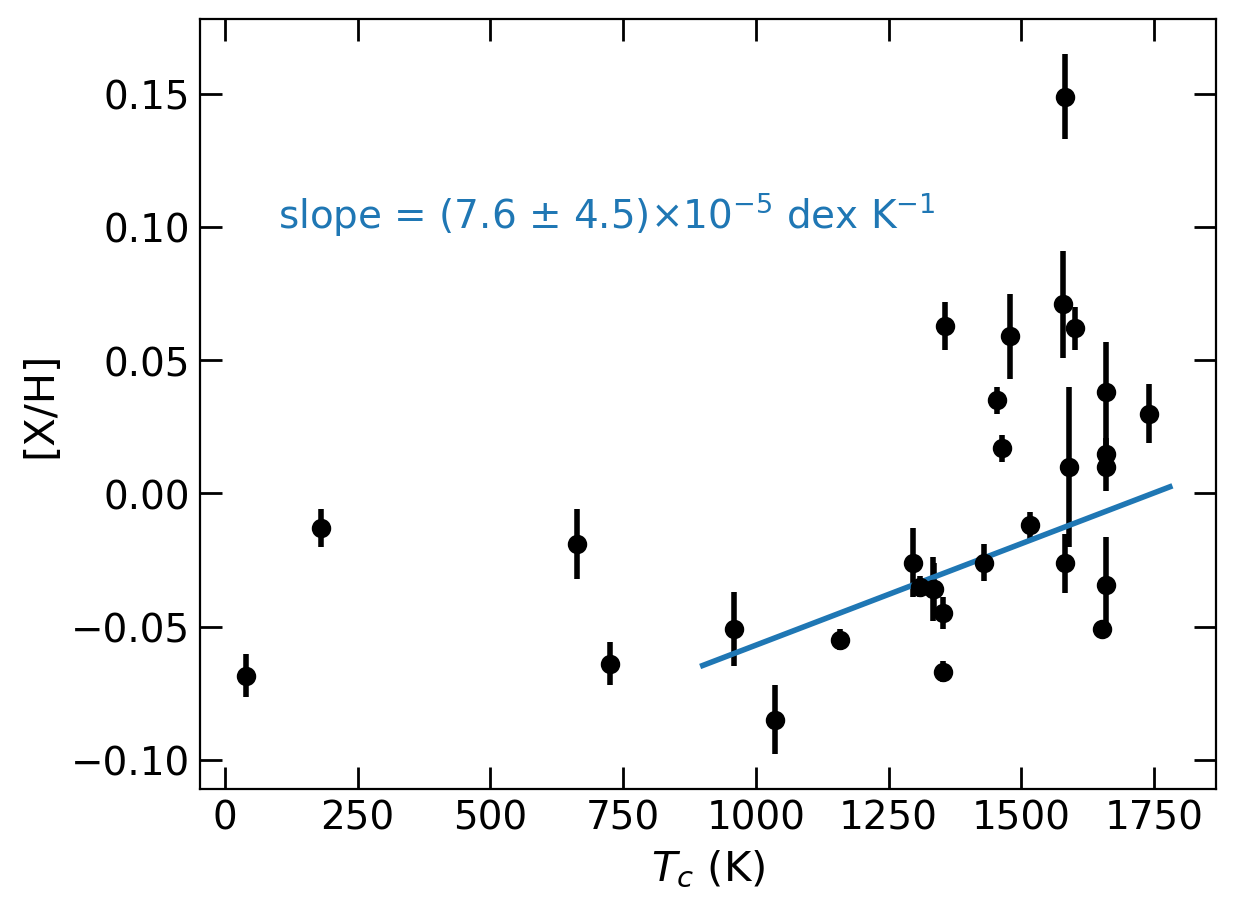

In [9]:
fig, ax = plt.subplots(1,1)
ax.errorbar(Tc, abund, err, fmt='o', color='k', mec='k', markersize=5, lw=2)
ax.plot(xs, linear(xs, *popt), lw=2)

'''
for el in ['C', 'O', 'Mg', 'Si']:
    ind = np.where(sp_names == el+'I')[0]
    x_txt, y_txt = Tc[ind]+1, abund[ind]+0.01
    if el == 'Mg':
        y_txt += 0.01
    if el == 'Si':
        y_txt += 0.02
    ax.text(x_txt, y_txt, el, fontsize=14, color='C2')
'''
    
ax.set_xlabel('$T_{c}$ (K)')
ax.set_ylabel('[X/H]')
ax.text(100, 0.12, r'slope = ({0:.1f} $\pm$ {1:.1f})'.format(popt[0]*1e5, perr[0]*1e5)+r'$\times 10^{-5}$ dex K$^{-1}$', color='C0')
fig.tight_layout()
plt.savefig('abundances.png');

In [43]:
len(abund)

30

In [10]:
popt[0], perr[0]

(7.627603460750223e-05, 4.480223596340319e-05)

In [12]:
tc_all = np.genfromtxt(data_dir+'Tc/harpstwins_tcslopes_w_ncapture.csv', delimiter=',', dtype=None, names=True, encoding=None)

In [14]:
slopes = tc_all['tc_slope_nov']

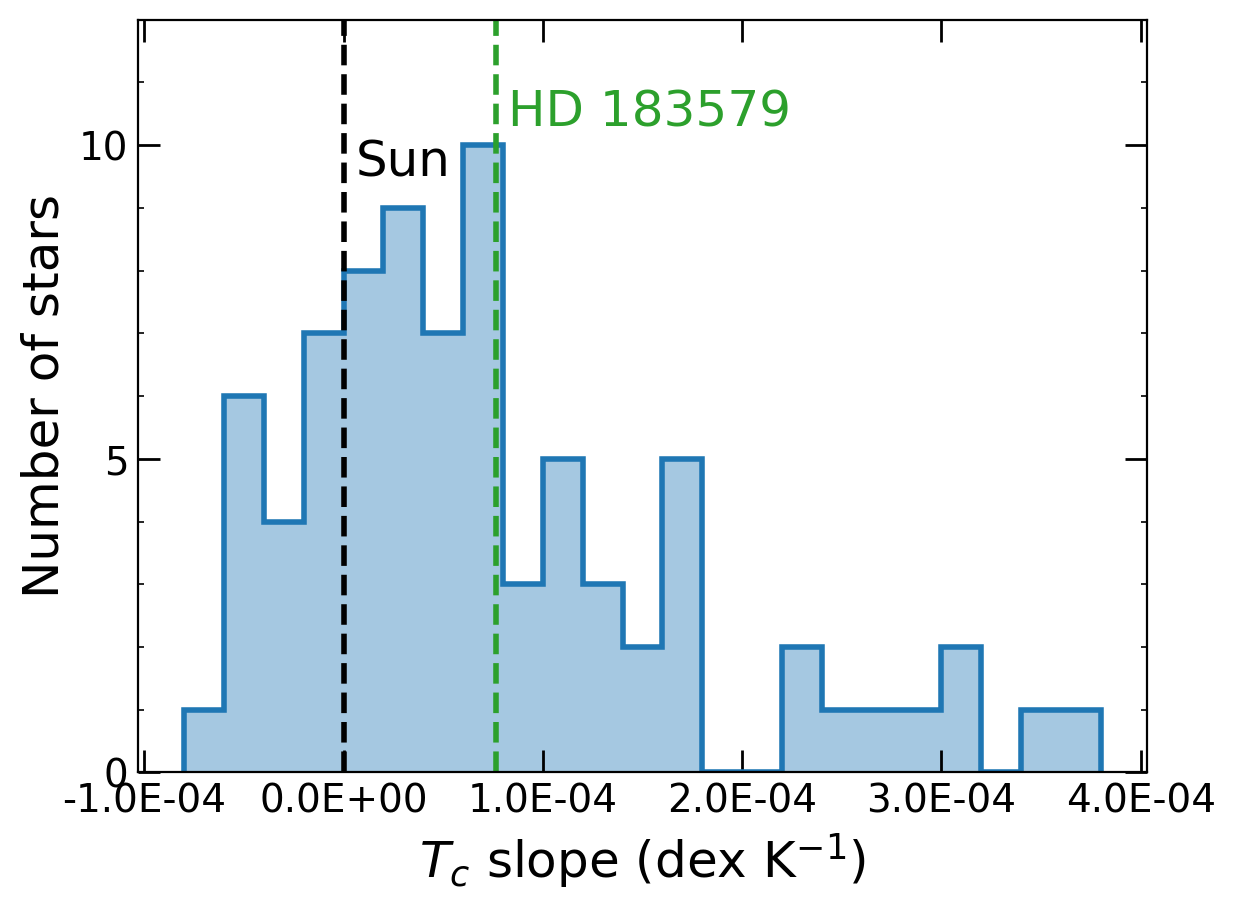

In [45]:
from matplotlib.ticker import FormatStrFormatter
fig,ax = plt.subplots(1,1)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1E'))

ax.hist(slopes, bins=np.arange(-8.e-5, 40.e-5, 2.e-5),histtype='stepfilled', alpha=0.4, color='C0', label='before GCE corrections')
ax.hist(slopes, bins=np.arange(-8.e-5, 40.e-5, 2.e-5), color='C0', lw=2, histtype='step')

ax.axvline(0.0, lw=2, color='k', ls='dashed')
ax.text(0.6e-5, 9.5, 'Sun', color='k', size=18)

ax.axvline(popt[0], lw=2, color='C2', ls='dashed')
ax.text(popt[0]+0.6e-5, 10.3, 'HD 183579', color='C2', size=18)

ax.tick_params(axis='x', labelsize=14)
ax.set_yticks(np.arange(0,12,5))
ax.set_yticks(np.arange(0,13,1), minor=True)

ax.set_xlabel(r'$T_{c}$ slope (dex K$^{-1}$)', fontsize=18)
ax.set_ylabel(r'Number of stars', fontsize=18)

fig.tight_layout()
plt.savefig('tchist.pdf');

In [46]:
np.median(slopes)

4.84391e-05